In [1]:
from cobra.io import load_model

model = load_model("textbook")
len(model.metabolites), len(model.reactions)

(72, 95)


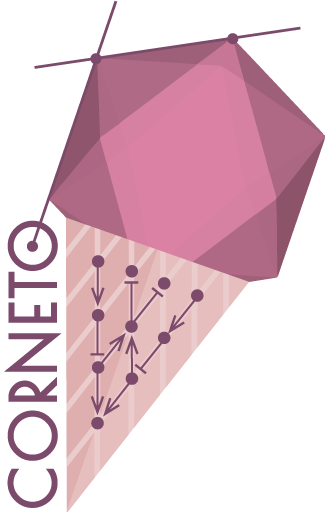

In [2]:
import corneto as cn

cn.info()

In [3]:
from corneto.methods.metabolism.fba import fba_problem

G = cn.Graph.from_cobra_model(model)
P = fba_problem(G)
P.expr

{'_flow': Variable((95,), _flow), 'flow': Variable((95,), _flow)}

In [4]:
rid = list(G.get_edges_by_attr("id", "Biomass_Ecoli_core"))[0]
biomass = P.expr.flow[rid]
P.add_objectives(biomass, weights=-1)
P.solve()
print(biomass.value)

0.8739215069684303


In [5]:
# Add custom constraints to the problem
P += biomass <= 0.5
P.solve(solver="SCIPY")
biomass.value

0.5

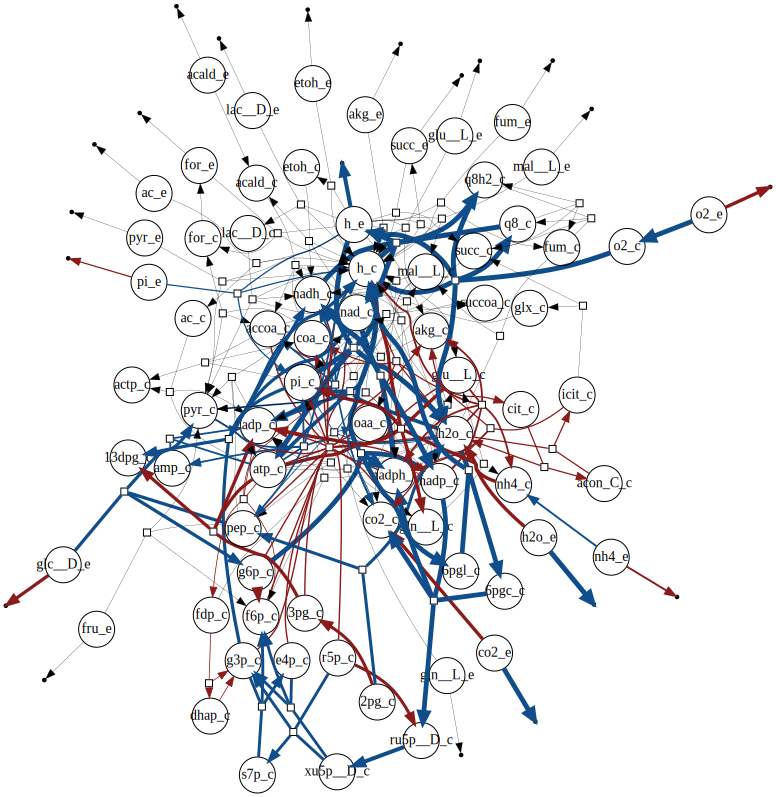

In [6]:
G.plot(custom_edge_attr=cn.pl.flow_style(P), layout="fdp")

In [7]:
from corneto.backend._base import Indicator

# Automatically create a new indicator variable for the flow
# If the indicator is 0, the flow is blocked, if it is 1, the flow is unblocked (can take any value within bounds, including 0)
P += Indicator("unblocked_flow")
P.expr

{'_flow': Variable((95,), _flow),
 'unblocked_flow': Variable((95,), unblocked_flow, boolean=True),
 'flow': Variable((95,), _flow)}

In [8]:
# We try to minimize the number of 1s (i.e., maximize reactions with blocked flux)
P.add_objectives(sum(P.expr.unblocked_flow))
P.solve()
print(biomass.value)

0.0


In [9]:
# How many reactions are unblocked?
sum(P.expr.unblocked_flow.value)

16.0

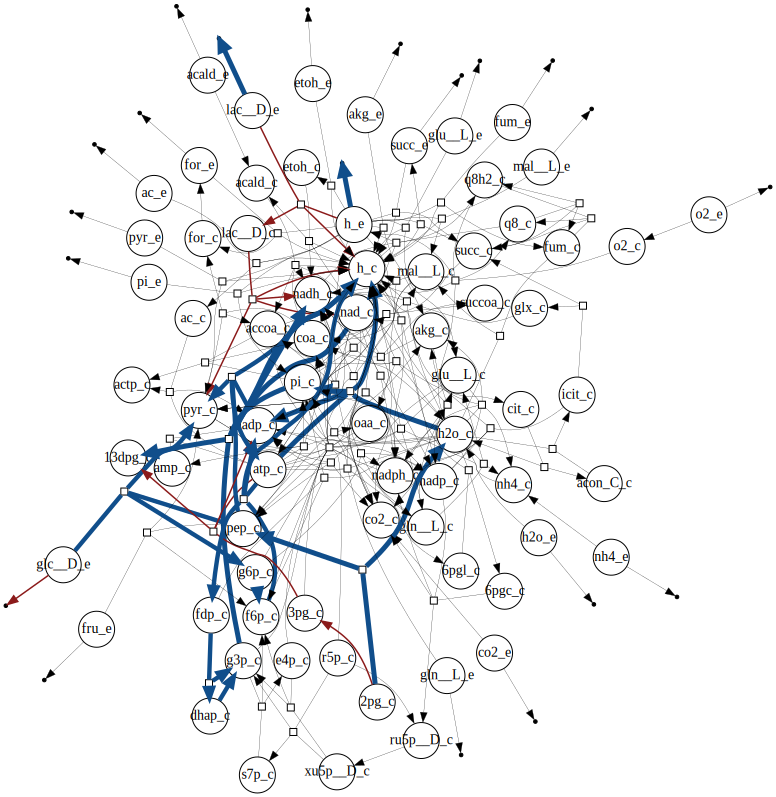

In [10]:
G.plot(custom_edge_attr=cn.pl.flow_style(P), layout="fdp")

In [11]:
P = fba_problem(G)
P += P.expr.flow[rid] >= 0.2
P += Indicator("unblocked_flow")
P.add_objectives(sum(P.expr.unblocked_flow))
P.solve(solver="SCIPY")

Problem(Minimize(Expression(AFFINE, NONNEGATIVE, ())), [Inequality(Constant(CONSTANT, UNKNOWN, (95,))), Inequality(Variable((95,), _flow)), Equality(Expression(AFFINE, UNKNOWN, (72,)), Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, NONNEGATIVE, ())), Inequality(Expression(AFFINE, UNKNOWN, (95,))), Inequality(Variable((95,), _flow))])

In [12]:
sum(P.expr.unblocked_flow.value)

42.0

In [13]:
sum(abs(P.expr.flow.value) >= 1e-6)

42